# Assignment 6

Due: Sunday, November 17, 2019

*Please complete all parts of this assignment within this notebook. You may leave the notebook file on the JupyterHub server (where it will be collected automatically on the due date).*

Use both Python code cells and Jupyter Markdown cells to complete the following exercises. Place your solution immediately after the corresponding question.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
sp.init_printing(use_latex='mathjax')

In this assignment, Problem A has been done for you. Run each cell as given. Read and try to understand how the solution is constructed. 

Then, for Problems B and C try and solve more complicated versions of the same problem. It may be helpful to copy-and-paste the complete solution for Problem A and then edit it to be the solution to Problems B and C.  The lines of code in Problem A that will need to modified are marked with the symbols `# <==` to try and help you. Also remember to edit the Markdown text within the question so that it is consistent with the question being answered.

- - -

### A. Atwood's machine

Atwood's machine consists of two masses ($m_1$ and $m_2$) hanging by a non-elastic rope of negligible mass running over a small, massless and frictionless pulley.  The rope is a length $L$ long and the pulley is a height $H$ off the ground. 

Find the position of the masses a function of time in terms of relavent parameters of the system assuming the heavier mass, $m_1$, starts from rest at a height of $y_0$ above the ground.

Let $m_1 = 5.1\;\mbox{kg}, m_2 = 5.0\;\mbox{kg}, g=9.8\;\mbox{m/s}^2, H=1.0\;\mbox{m}, L= 0.8\;\mbox{m},$ and $y_{0}=0.9\;\mbox{m}$.


***Solution***

We start by declaring the symbols we will need in this problem:

In [299]:
m1, m2, t, H, L, g, T = sp.symbols('m1, m2, t, H, L, g, T')     # <==
y1, y2 = sp.symbols('y1, y2', cls=sp.Function)                  # <==

Because of the geometrical setup of the system, the accelerations of the masses are equal in magnitude and opposite in direction.  But, another way of describing this geomtrical requirement is to write a *constraint equation* that must always equal to zero.

In [300]:
constraint = y1(t) + y2(t) + L - 2*H                            # <==
constraint

-2⋅H + L + y₁(t) + y₂(t)

Notice that if you take the second derivative with $t$ for this equation, you recover the same idea that says $a_1 = -a_2$. 

In [301]:
constraint.diff(t, t)

  2            2       
 d            d        
───(y₁(t)) + ───(y₂(t))
  2            2       
dt           dt        

Here is Newton's Law applied to mass 1,

In [302]:
eq1 = m1 * y1(t).diff(t, t) + m1 * g - T                        # <==
eq1

                 2       
                d        
-T + g⋅m₁ + m₁⋅───(y₁(t))
                 2       
               dt        

and also applied to mass 2

In [303]:
eq2 = m2 * y2(t).diff(t, t) +  m2 * g - T                       # <==
eq2

                 2       
                d        
-T + g⋅m₂ + m₂⋅───(y₂(t))
                 2       
               dt        

Using the constraint, we can solve for $y_2(t)$ as the expression `y2_`

In [304]:
y2_ = sp.solve(constraint, y2(t))[0]
y2_

2⋅H - L - y₁(t)

This allow us to replace $y_2(t)$ in equation (2) with this expression to get the new equation

In [305]:
eq3 = eq2.subs({y2(t): y2_}).doit()
eq3

                 2       
                d        
-T + g⋅m₂ - m₂⋅───(y₁(t))
                 2       
               dt        

Likewise, we can solve equation (3) for $T$ as the expression `T_`

In [306]:
T_ = sp.solve(eq3, T)[0]
T_

   ⎛      2       ⎞
   ⎜     d        ⎟
m₂⋅⎜g - ───(y₁(t))⎟
   ⎜      2       ⎟
   ⎝    dt        ⎠

Substituting back into equation (1) gives

In [307]:
eq4 = eq1.subs({T: T_}).doit()
eq4

            2             ⎛      2       ⎞
           d              ⎜     d        ⎟
g⋅m₁ + m₁⋅───(y₁(t)) - m₂⋅⎜g - ───(y₁(t))⎟
            2             ⎜      2       ⎟
          dt              ⎝    dt        ⎠

Equation (4) is a differential equation that could be solved with `sp.dsolve()`.  Instead, we are going to solve for the acceleration of mass 1 so that we can solve the problem numerically.

In [308]:
a1 = sp.solve(eq4, y1(t).diff(t, t))[0]
a1

g⋅(-m₁ + m₂)
────────────
  m₁ + m₂   

Here are the numerical parameters for this problem.

In [309]:
params = {m1:5.1, m2:5.0, g:9.8, H:1.0, L:0.8 }                   # <==

We can define a NumPy function that evaluates the second derivative in terms of $t$, $y_1(t)$, and $\frac{d y_1}{dt}$. 

(*For this particular problem the accleration is constant, but in general could depend on $t$, $y_1$, and $v_1 = \frac{d y_1}{dt}$*)

In [310]:
dvdt = sp.lambdify( (t, y1(t), y1(t).diff(t)), a1.subs(params) )

We can solve the problem numerically using the SciPy solver `odeint`.

In [311]:
from scipy.integrate import odeint

def RHS(s, t):
    y, v = s
    return [v, dvdt(t, y, v)]

t_ = np.arange(0, 1, 0.01)

y0 = 0.9
v0 = 0
s0 = [y0, v0]

soln = odeint(RHS, s0, t_)

data = pd.DataFrame(soln, columns=['y1', 'v'])
data['t'] = t_

We can also evaluate the function $y_2(t)$

In [312]:
y2_                                                              # <==

2⋅H - L - y₁(t)

by evaluating the above expression as a function of $y_1$

In [313]:
y2 = sp.lambdify(y1(t), y2_.subs(params))                        # <==
data['y2'] = y2(data.y1)                                         # <==

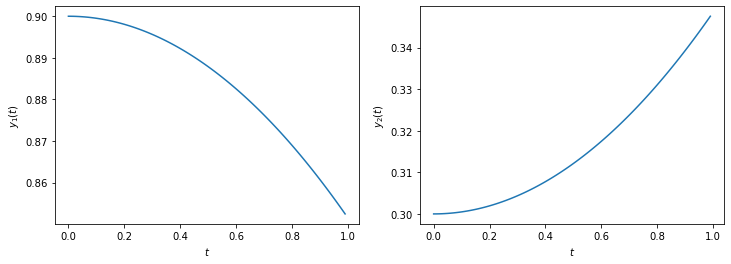

In [314]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(data.t, data.y1)
axs[0].set_ylabel('$y_1(t)$')
axs[0].set_xlabel('$t$')

axs[1].plot(data.t, data.y2)                                     # <==
axs[1].set_ylabel('$y_2(t)$')                                    # <==
axs[1].set_xlabel('$t$')

plt.show()

The above plot shows that heavier mass falls down while the lighter mass rises up.

- - -
## B. Atwood's machine over a table

An Atwood's machine is constructed with two masses ($m_1$ and $m_2$) attached with a rope of negligible mass running over a small, massless and frictionless pulley.  The rope is a length $L$ long and the pulley is a height $H$ off the ground. 

In this problem, the heavier mass, $m_2$, lies on a frictionless table of height $H$ and is connected by a rope running parallel to the table through a pulley to the lighter mass, $m_1$, which is hanging vertically.  Use the symbols $y_1(t)$ and $x_2(t)$ to make it clearer that the lighter mass, $m_1$ moves vertically and the heavier mass, $m_2$ moves horizontally.  Consider a coordinate system where the ground is at $y=0$, the pulley is $x=0$, and the mass on the table starts off to the right with $x_2 > 0$.

Find the position of the masses a function of time in terms of relavent parameters of the system assuming the lighter mass, $m_1$, starts from rest at a height of $y_0$ above the ground. (**Note**: *$m_1$ is now the lighter of the two masses*)

Let $m_1 = 1.0\;\mbox{kg}, m_2 = 5.0\;\mbox{kg}, g=9.8\;\mbox{m/s}^2, H=1.0\;\mbox{m}, L= 0.8\;\mbox{m},$ and $y_{0}=0.9\;\mbox{m}$.


***Solution***

- - -
## C. Atwood's machine over a table with an angle

An Atwood's machine is constructed with two masses ($m_1$ and $m_2$) attached with a rope of negligible mass running over a small, massless and frictionless pulley.  The rope is a length $L$ long and the pulley is a height $H$ off the ground. 

In this problem, the heavier mass, $m_2$, lies on a frictionless table of height $h$ (where $h < H$) and is connected by a rope running through a pulley to the lighter mass, $m_1$, which is hanging vertically.  The difference here is that the angle that the rope makes to the table is now changing with time and so the tension on the rope is no longer a constant.  You may assume that the heavier mass always remains on the table. Importantly, it is no longer true that the magnitude of the accleration of these two masses are still the same. Again, use the symbols $y_1(t)$ and $x_2(t)$ to make it clearer that the lighter mass, $m_1$ moves vertically and the heavier mass, $m_2$ moves horizontally.

Find the position of the masses a function of time in terms of relavent parameters of the system assuming the heavier mass, $m_1$, starts from rest at a height of $y_0$ above the ground.

Let $m_1 = 1.0\;\mbox{kg}, m_2 = 5.0\;\mbox{kg}, g=9.8\;\mbox{m/s}^2, H=1.0\;\mbox{m}, L= 0.8\;\mbox{m}, y_{0}=0.9\;\mbox{m},$ and $h=0.5\;\mbox{m}$.


***Solution***